In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\DELL\Desktop\FN_Final\Model\final_dataset.csv")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185803 entries, 0 to 185802
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   185803 non-null  int64 
 1   text    185803 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [3]:
df.columns.tolist()

['label', 'text']

In [4]:
df.head()
#  1 = True / 0 = False

,label,text
0,0,did miley cyrus and liam hemsworth secretly ge...
1,0,paris jackson & cara delevingne enjoy night ou...
2,0,celebrities join tax march in protest of donal...
3,0,cindy crawfords daughter kaia gerber wears a w...
4,0,full list of 2018 oscar nominations – variety


In [5]:
pip install -r C:\Users\DELL\Desktop\FN_Final\Model\requirements.txt

  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached peft-0.15.2-py3-none-any.whl.metadata (13 kB)
  Using cached accelerate-1.7.0-py3-none-any.whl.metadata (19 kB)
  Using cached bitsandbytes-0.46.0-py3-none-manylinux_2_24_x86_64.whl.metadata (10 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 25.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 156.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 196.7 MB/s eta 0:00:

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"/teamspace/studios/this_studio/final_dataset.csv")

# Supprimer les lignes où la colonne "label" est NaN ou inf
df = df[~df["label"].isna()]  # enlève les NaN
df = df[~df["label"].isin([np.inf, -np.inf])]  # enlève les infinis

# convertir en entier
df["label"] = df["label"].astype(int)


In [7]:
from sklearn.model_selection import train_test_split

import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Split train / test
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

In [8]:
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

In [9]:
from transformers import BertTokenizer

#initialiser le tokenizer de BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
#Tokenization
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

In [11]:
import torch
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

In [12]:
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

# Fine-Tuning de BERT


In [13]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from datasets import Dataset

#### Chargement du modéle BERT avec QLoRA (4-bit)

In [14]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto"
)

model = prepare_model_for_kbit_training(base_model)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 2,680,322 || all params: 112,164,100 || trainable%: 2.3896


In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels,
                                                               preds, 
                                                               average='binary',
                                                               zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [18]:
# add this check before creating the Trainer
if val_dataset is None:
    print("ERROR: val_dataset is None")
elif len(val_dataset) == 0:
    print("ERROR: val_dataset is empty")
else:
    print(f"val_dataset has {len(val_dataset)} samples")

# pour stocker les scores dans un fichier
from transformers import TrainerCallback
import json

class SaveMetricsCallback(TrainerCallback):
    def __init__(self, path="metrics_log.json"):
        self.path = path
        self.metrics = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            self.metrics.append({"epoch": state.epoch, "step": state.global_step, **metrics})
            with open(self.path, "w") as f:
                json.dump(self.metrics, f, indent=2)


val_dataset has 37161 samples


In [11]:
training_args = TrainingArguments(
    output_dir="./results-qlora",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none",
    learning_rate=2e-4,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback()]
)


NameError: name 'Trainer' is not defined

In [20]:
trainer.train()

/tmp/ipykernel_3480/4271902066.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(val[idx])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.158600,0.106500,0.964156,0.968154,0.951412,0.985495
2,0.082700,0.089027,0.971637,0.974540,0.967343,0.981845
3,0.056200,0.087572,0.973009,0.975820,0.966708,0.985106
4,0.037000,0.099566,0.974220,0.976777,0.972956,0.980628


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error 503 Server Error: Service Temporarily Unavailable for url: https://huggingface.co/bert-base-uncased/resolve/main/config.json - silently ignoring the lookup for the file config.json in bert-base-uncased.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in bert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(
/tmp/ipykernel_3480/4271902066.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(val[idx])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils

TrainOutput(global_step=37164, training_loss=0.08359978486667625, metrics={'train_runtime': 71512.3097, 'train_samples_per_second': 8.314, 'train_steps_per_second': 0.52, 'total_flos': 1.61333056661717e+17, 'train_loss': 0.08359978486667625, 'epoch': 4.0})

In [21]:
model.save_pretrained("my_model/")
tokenizer.save_pretrained("my_model/")

('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json')

"Nous avons évalué les performances du modèle à chaque époque. Le score F1 converge dès la 4e époque, ce qui justifie le choix d’un nombre d’époques réduit pour éviter l’overfitting."

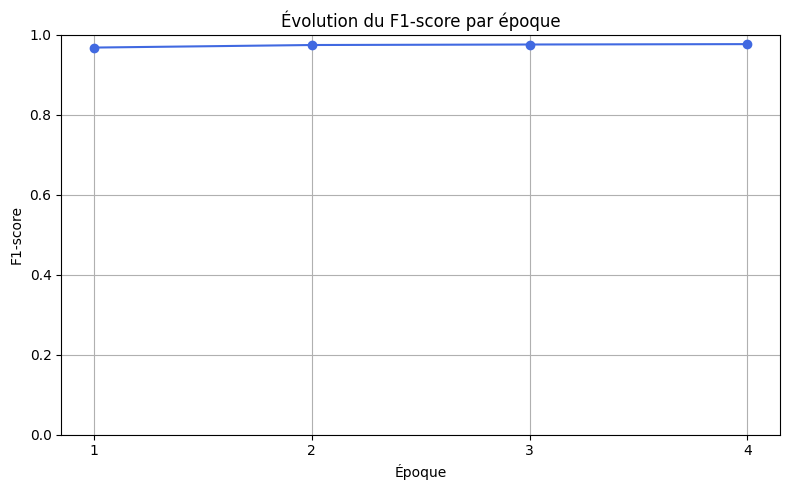

In [22]:
import json
import matplotlib.pyplot as plt

# Charger les métriques
with open("/teamspace/studios/this_studio/metrics_log.json", "r") as f:
    metrics = json.load(f)

# Extraire les données
epochs = [m["epoch"] for m in metrics]
f1_scores = [m["eval_f1"] for m in metrics]

# Tracer la courbe
plt.figure(figsize=(8, 5))
plt.plot(epochs, f1_scores, marker="o", color="royalblue")
plt.title("Évolution du F1-score par époque")
plt.xlabel("Époque")
plt.ylabel("F1-score")
plt.grid(True)
plt.xticks(epochs)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("courbe_f1.png")
plt.show()


# New 

### Analyse d’erreurs

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import pandas as pd

# Prédictions brutes
pred_outputs = trainer.predict(val_dataset)
pred_logits = pred_outputs.predictions
pred_probs = F.softmax(torch.tensor(pred_logits), dim=1)
pred_labels = torch.argmax(pred_probs, dim=1).numpy()

# Rapport de classification
print(classification_report(val_labels, pred_labels))

# Créer DataFrame des erreurs
errors_df = pd.DataFrame({
    "Text": val_texts,
    "True Label": val_labels,
    "Predicted Label": pred_labels,
    "Confidence Fake (%)": (pred_probs[:, 1].numpy() * 100).round(2)
})

# Filtrer les erreurs
errors_only = errors_df[errors_df["True Label"] != errors_df["Predicted Label"]]

# Afficher les erreurs (les 10 premières)
pd.set_option("display.max_colwidth", None)
display(errors_only.head(10))


/tmp/ipykernel_3480/4271902066.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(val[idx])


              precision    recall  f1-score   support

           0       0.98      0.97      0.97     16616
           1       0.97      0.98      0.98     20545

    accuracy                           0.97     37161
   macro avg       0.97      0.97      0.97     37161
weighted avg       0.97      0.97      0.97     37161



,Text,True Label,Predicted Label,Confidence Fake (%)
36,kourtney & kim kim allergic to cats,0,1,96.470001
39,taylor swift just gave a sneaky response to the internets joe alwyn breakup speculation,0,1,80.519997
90,taylor swift spent her fourth of july in turks and caicos with boyfriend joe alwyn,0,1,98.720001
133,inside khloe kardashian and tristan thompsons babys nursery,0,1,90.900002
136,marilyn mosby held a press conference today in which she said police officers had no probable cause to arrest freddie gray that s a lie freddie gray had an active warrant out for his arrest so baltimore police had every reason to bring him in,0,1,99.589996
164,harry hamlin,1,0,40.450001
270,george hw bush has died at 94 – new york,0,1,99.870003
292,inside maksim chmerkovskiy & peta murgatroyds marital issues,0,1,82.959999
327,britney spears kevin federline settle child support case,1,0,2.260000
395,scott disick & younes bendjima’s ‘awkward’ run-in at xmas party there was ‘definite tension’,0,1,71.809998


####  Générer et insérer dans ton mémoire :

###### À ajouter dans le mémoire :

###### La courbe de perte générée à partir des logs de l'entraînement permet de visualiser la convergence du modèle au fil des étapes d’apprentissage.

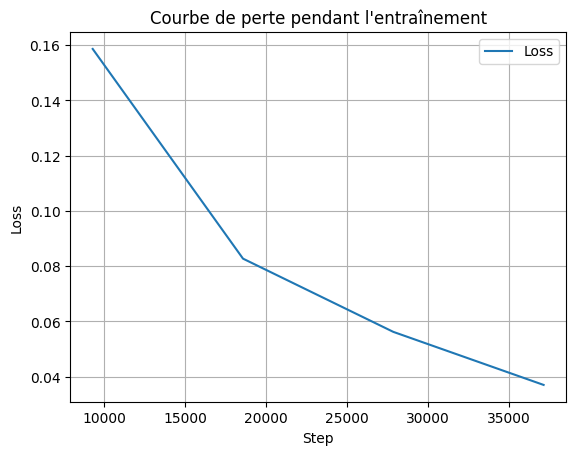

In [6]:
import json
import matplotlib.pyplot as plt

with open(r"C:\Users\DELL\Desktop\FN_Final\Model\backend\results-qlora\checkpoint-37164\trainer_state.json") as f:
    state = json.load(f)

losses = [l["loss"] for l in state["log_history"] if "loss" in l]
steps = [l["step"] for l in state["log_history"] if "loss" in l]

plt.plot(steps, losses, label="Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Courbe de perte pendant l'entraînement")
plt.legend()
plt.grid()
plt.show()


✅ 3. Faire une analyse d'erreurs qualitative
Reprends quelques exemples mal classés à partir des prédictions du modèle sauvegardé (faux positifs/faux négatifs). Tu peux les afficher dans ton mémoire sous forme de tableau :

Exemple (tronqué)	Label réel	Prédiction	Type d’erreur


“Le vaccin cause…”	FAKE    	REAL	    Faux négatif

📌 Dans ton mémoire :

Une analyse qualitative a été menée sur les erreurs de prédiction. Elle révèle que certains contenus à tonalité ironique ou ambigus sont mal classés, ce qui met en évidence les limites de la compréhension contextuelle du modèle.

#####################################################